# Face Anti Spoofing Neural Network

In [0]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Fonction d'affichage

In [0]:
def imshow_np(img):
  height,width,depth = img.shape
  if depth==1:
      img=img[:,:,0]
  plt.imshow(img)
  plt.show()

def imshow(img):
  imshow_np(img.numpy())

## Création des jeux de données

In [0]:
#creation des donnees:

#Images
Images = np.load('images_sample.npz')

#Changement de base
Anchors = np.load('anchors_sample.npz')
  
#label_D:
Labels_D = np.load('labels_D_sample.npz')

#label_spoofing:
Labels = np.load('label_sample.npz')

#set:
n=len(Images)

data_images = np.zeros((n,256,256,3),dtype=np.float32)
data_anchors = np.zeros((n,2,4096),dtype=np.float32)
data_labels_D = np.zeros((n,32,32,1),dtype=np.float32)
data_labels = np.zeros((n),dtype=np.float32)

for item in Images.files:
  data_images[int(item),:,:,:] = Images[item]
  data_anchors[int(item),:,:] = Anchors[item]
  data_labels_D[int(item),:,:,:] = Labels_D[item]
  data_labels[int(item)] = Labels[item]

In [0]:
training_part = 45/55
n_train = int(n*training_part)

#Training set
data_images_train = data_images[:n_train,:,:,:]
data_anchors_train = data_anchors[:n_train,:,:]
data_labels_D_train = data_labels_D[:n_train,:,:,:]
data_labels_train = data_labels[:n_train]

#Test set
data_images_test = data_images[n_train:,:,:,:]
data_anchors_test = data_anchors[n_train:,:,:]
data_labels_D_test = data_labels_D[n_train:,:,:,:]
data_labels_test = data_labels[n_train:]

In [0]:
def prepare_dataloader_D(data_images_train,data_images_test,data_labels_D_train,data_labels_D_test):
  
  trainset_D = torch.utils.data.TensorDataset(torch.tensor(np.transpose(data_images_train, (0, 3, 1, 2))), torch.tensor(data_labels_D_train))
  testset_D = torch.utils.data.TensorDataset(torch.tensor(np.transpose(data_images_test, (0, 3, 1, 2))), torch.tensor(data_labels_D_test))

  trainloader_D = torch.utils.data.DataLoader(trainset_D,batch_size=5,shuffle=False)
  testloader_D = torch.utils.data.DataLoader(testset_D,batch_size=5,shuffle=False)

  return trainloader_D, testloader_D

trainloader_D,testloader_D = prepare_dataloader_D(data_images_train,data_images_test,data_labels_D_train,data_labels_D_test)

## Création du modèle

In [8]:
import Anti_Spoof_net

mon_model = Anti_Spoof_net.Anti_spoof_net()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mon_model.parameters(),lr=3e-3,betas=(0.9, 0.999),eps=1e-08)

/content/Anti_spoof_net_CNN.py:15: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.cnn0.weight)
/content/Anti_spoof_net_CNN.py:20: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.cnn01.weight)
/content/Anti_spoof_net_CNN.py:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.cnn1.weight)
/content/Anti_spoof_net_CNN.py:31: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.cnn2.weight)
/content/Anti_spoof_net_CNN.py:36: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.cnn3.weight)


## Entraînement

In [0]:
def train_CNN(net, optimizer, trainloader, data_anchors, criterion, n_epoch = 10):
  total = 0
  for epoch in range(n_epoch):
    # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      #Donnees pre-crees:
      images, labels_D = data
      # training step
      optimizer.zero_grad()
      outputs_D, _ = net(images,False,data_anchors[i:i+5,:,:])
      #handle NaN:
      if (torch.norm((outputs_D != outputs_D).float())==0):   
        if (i%50==0 or i%50==1):
          imshow_np(np.transpose(images[0,:,:,:].numpy(),(1,2,0)))
          imshow_np(np.transpose(outputs_D[0,:,:,:].detach().numpy(),(1,2,0)))
        loss = criterion(outputs_D, labels_D)
        loss.backward()
        optimizer.step()
        # compute statistics
        total += labels_D.size(0)
        running_loss += loss.item()
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / total))
    print('Epoch finished')
  print('Finished Training')

In [0]:
def train_RNN(net, optimizer, trainloader, anchors, labels, criterion, n_epoch = 10):
  total = 0
  for epoch in range(n_epoch):
    # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      #Donnees pre-crees:
      images, labels_D = data
      # training step
      optimizer.zero_grad()
      _, outputs_F = net(images,False,anchors[i:i+1,:,:])
      #handle NaN:
      if (torch.norm((outputs_F != outputs_F).float())==0):   
        if (i%50==0 or i%50==1):
          imshow_np(np.transpose(images[0,:,:,:].numpy(),(1,2,0)))
          print('F:')
          print(outputs_F)
        if labels[i*5]==0: #toutes les images du batch proviennent de la même vidéo
          label=torch.zeros((5,1,2),dtype=torch.float32)
        else:
          label=torch.ones((5,1,2),dtype=torch.float32)
        loss = criterion(outputs_F, label)
        loss.backward()
        optimizer.step()
        # compute statistics
        total += labels_D.size(0)
        running_loss += loss.item()
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / total))
    print('Epoch finished')
  print('Finished Training')

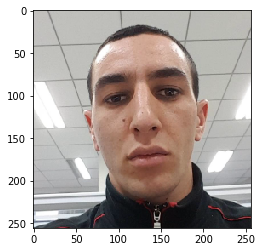

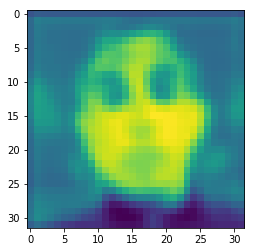

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([5, 32, 32, 1])) that is different to the input size (torch.Size([5, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1,     1] loss: 1398.624


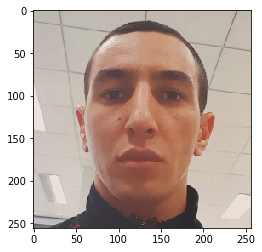

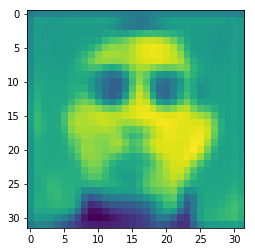

[1,     2] loss: 950.567
[1,     3] loss: 857.545
[1,     4] loss: 712.378
[1,     5] loss: 596.351
[1,     6] loss: 859.729
[1,     7] loss: 742.196


KeyboardInterrupt: ignored

In [37]:
def train_All(net, optimizer, trainloader, anchors, labels, criterion, n_epoch = 10):
  for i in range(n_epoch):
    train_CNN(net, optimizer, trainloader_D, data_anchors_train, criterion, n_epoch = 1)
    torch.save(net,'mon_model')
    train_RNN(net, optimizer, trainloader_D, data_anchors_train, data_labels_train, criterion, n_epoch = 1)
    torch.save(net,'mon_model')
    
mon_model = torch.load('mon_model')
outputs = train_All(mon_model, optimizer, trainloader_D,data_anchors_train, data_labels_train, criterion, n_epoch = 10)

In [0]:
mon_model = torch.load('mon_model')

In [0]:
def accuracy(net, criterion, testloader, labels):
  correct = 0
  total = 0
  l=0.015
  for i, (images, _ ) in enumerate(testloader,0):
      outputs_D, outputs_F = net(images,False,data_anchors_test[i:i+1,:,:])
      critere = torch.norm(outputs_D)+l*torch.norm(outputs_F)  
      ##850 a été choisi pour retrouver en moyenne les même résultats que dans le papier de recherche
      if (critere>850 and label==1):
        correct+=1
      if (critere<850 and label==0):
        correct==1
      total+=1
      print(correct/total)
  accuracy =  correct / total
  loss = loss/total
  return accuracy, loss

accuracy(mon_model, criterion, testloader_D, data_labels_test)

tensor(920.5055, grad_fn=<AddBackward0>)
tensor(802.8559, grad_fn=<AddBackward0>)
tensor(881.9680, grad_fn=<AddBackward0>)
tensor(828.4318, grad_fn=<AddBackward0>)
tensor(867.0123, grad_fn=<AddBackward0>)
